#Importation

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, BatchNormalization, Dense, AvgPool2D,MaxPool2D
from sklearn.metrics import confusion_matrix
from numpy.random import seed
import glob
seed(8) 
import tensorflow
tensorflow.random.set_seed(7)
import pandas as pd 
import os
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.keras import optimizers



# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# mount drive and download dataset


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/My Drive/kaggle_dataset

/content/gdrive/My Drive/kaggle_dataset


In [ ]:
!ls

covid  kaggle.json


In [ ]:
#!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

In [ ]:
#!mkdir covid
#!mv covid19-radiography-database.zip covid

In [ ]:
%cd covid/

/content/gdrive/My Drive/kaggle_dataset/covid


In [ ]:
!ls

'COVID-19 Radiography Database'   model_vgg19   my_model.h5
 model_coronet			  my_model     'Viral Pneumonia'


In [ ]:
#!unzip covid19-radiography-database.zip

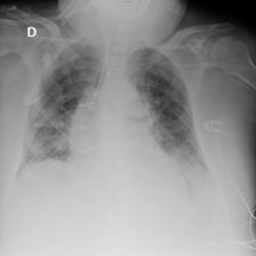

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/gdrive/MyDrive/kaggle_dataset/covid/COVID-19 Radiography Database/COVID/COVID (100).png')
cv2_imshow(img)

In [ ]:
%cd COVID-19\ Radiography\ Database
!ls

/content/gdrive/MyDrive/kaggle_dataset/covid/COVID-19 Radiography Database
 COVID		       NORMAL		      README.md.txt
 COVID.metadata.xlsx   NORMAL.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'


# Use the Image Data Generator to import the images from the dataset


In [ ]:


DATASET_PATH = "/content/gdrive/MyDrive/kaggle_dataset/covid/COVID-19 Radiography Database"

IMAGE_SIZE    = (256, 256)
IMG_W,IMG_H = IMAGE_SIZE
NUM_CLASSES   = 2
BATCH_SIZE    = 10
NUM_EPOCHS    = 10
LEARNING_RATE =0.0001



train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   #zca_whitening = True,
                                   #channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   validation_split = 0.2,
                                   #fill_mode='constant'
                                   )




train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary"   
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary"  
                                                 
                                                  )

Found 2033 images belonging to 2 classes.
Found 508 images belonging to 2 classes.


In [ ]:
train_batches.class_indices

{'COVID': 0, 'NORMAL': 1}

In [ ]:
classes=["COVID","NORMAL"]

# CoroNet

The model uses Xception as base model pre-trained on ImageNet, retrained on Chest X-rays dataset

In [ ]:
my_model = tf.keras.models.load_model('/content/gdrive/MyDrive/kaggle_dataset/covid/CoroNet.h5')

In [ ]:

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))


conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)




model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',     
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE,decay=LEARNING_RATE / NUM_EPOCHS),
              metrics=['acc',tf.keras.metrics.Recall()])

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 54,416,425
Trainable params: 33,554,945
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [ ]:
#FIT MODEL
NUM_EPOCHS    = 25
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result_CoroNet=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )

204
51


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
203/203 [==============================] - 80s 373ms/step - loss: 0.1933 - acc: 0.9445 - recall: 0.9555 - val_loss: 0.0438 - val_acc: 0.9860 - val_recall: 0.9887
Epoch 2/25
203/203 [==============================] - 74s 366ms/step - loss: 0.0815 - acc: 0.9813 - recall: 0.9820 - val_loss: 0.0308 - val_acc: 0.9920 - val_recall: 0.9962
Epoch 3/25
203/203 [==============================] - 74s 366ms/step - loss: 0.0586 - acc: 0.9792 - recall: 0.9789 - val_loss: 0.0455 - val_acc: 0.9880 - val_recall: 0.9811
Epoch 4/25
203/203 [==============================] - 74s 365ms/step - loss: 0.0520 - acc: 0.9882 - recall: 0.9904 - val_loss: 0.0369 - val_acc: 0.9920 - val_recall: 0.9962
Epoch 5/25
203/203 [==============================] - 74s 363ms/step - loss: 0.0764 - acc: 0.9841 - recall: 0.9866 - val_loss: 0.0067 - val_acc: 0.9960 - val_recall: 0.9963
Epoch 6/25
203/203 [==============================] - 74s 365ms/step - loss: 0.0728 - acc: 0.9793 - recall: 0.9802 - val_loss: 0.0614 -

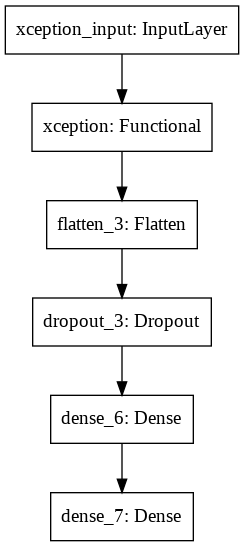

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(result_CoroNet.model)

Text(0.5, 1.0, 'train_loss vs val_loss')

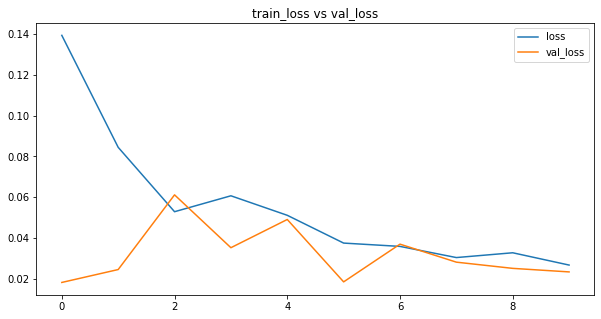

In [ ]:
# Plotting train_loss vs val_loss
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
plt.plot(result_CoroNet.history["loss"],label="loss")
plt.plot(result_CoroNet.history["val_loss"],label="val_loss")
plt.legend()
plt.title("train_loss vs val_loss")

Text(0.5, 1.0, 'train_accuracy vs train recall')

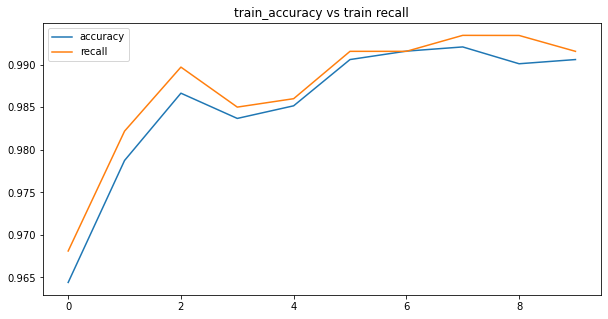

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(result_CoroNet.history["acc"],label="accuracy")
plt.plot(result_CoroNet.history["recall_3"],label="recall")
plt.legend(loc='upper left')
plt.title("train_accuracy vs train recall")

Text(0.5, 1.0, 'train_accuracy vs Val_accuracy')

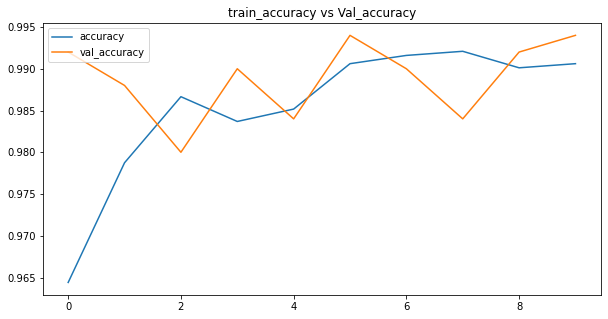

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(result_CoroNet.history["acc"],label="accuracy")
plt.plot(result_CoroNet.history["val_acc"],label="val_accuracy")
plt.legend(loc='upper left')
plt.title("train_accuracy vs Val_accuracy")

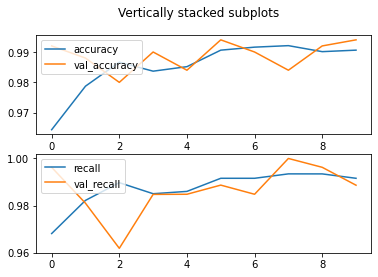

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')



ax1.plot(result_CoroNet.history["acc"],label="accuracy")
ax1.plot(result_CoroNet.history["val_acc"],label="val_accuracy")
ax1.legend(loc='upper left')


ax2.plot(result_CoroNet.history["recall_3"],label="recall")
ax2.plot(result_CoroNet.history["val_recall_3"],label="val_recall")
ax2.legend(loc='upper left')



In [ ]:
#save model to drive 
result_CoroNet.model.save('/content/gdrive/MyDrive/kaggle_dataset/covid/COVID-19 Radiography Database/model_coronet')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/kaggle_dataset/covid/COVID-19 Radiography Database/model_coronet/assets


In [ ]:
result_CoroNet.model.save('/content/gdrive/MyDrive/kaggle_dataset/covid/CoroNet.h5')

# Transfer Learning VGG

In [ ]:
my_model = tf.keras.models.load_model('/content/gdrive/MyDrive/kaggle_dataset/covid/model_VGG19.h5')

In [ ]:


conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))


conv_base.trainable = True


model = models.Sequential()
model.add(conv_base)




model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',     
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc',tf.keras.metrics.Recall()])

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in conv_base.layers:
    print(layer.name)

input_45
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 28,413,505
Trainable params: 28,413,505
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))
NUM_EPOCHS    = 25
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result_VGG19=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )

204
51


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
203/203 [==============================] - 123s 582ms/step - loss: 0.3656 - acc: 0.8511 - recall_1: 0.8519 - val_loss: 0.1547 - val_acc: 0.9680 - val_recall_1: 0.9773
Epoch 2/25
203/203 [==============================] - 115s 567ms/step - loss: 0.1267 - acc: 0.9695 - recall_1: 0.9640 - val_loss: 0.0559 - val_acc: 0.9900 - val_recall_1: 0.9848
Epoch 3/25
203/203 [==============================] - 115s 567ms/step - loss: 0.0824 - acc: 0.9749 - recall_1: 0.9744 - val_loss: 0.0911 - val_acc: 0.9740 - val_recall_1: 0.9545
Epoch 4/25
203/203 [==============================] - 115s 568ms/step - loss: 0.0585 - acc: 0.9883 - recall_1: 0.9927 - val_loss: 0.2026 - val_acc: 0.9500 - val_recall_1: 0.9427
Epoch 5/25
203/203 [==============================] - 115s 565ms/step - loss: 0.1261 - acc: 0.9531 - recall_1: 0.9655 - val_loss: 0.1363 - val_acc: 0.9580 - val_recall_1: 0.9242
Epoch 6/25
203/203 [==============================] - 115s 566ms/step - loss: 0.1013 - acc: 0.9761 - recall_1:

Text(0.5, 1.0, 'train_loss vs val_loss')

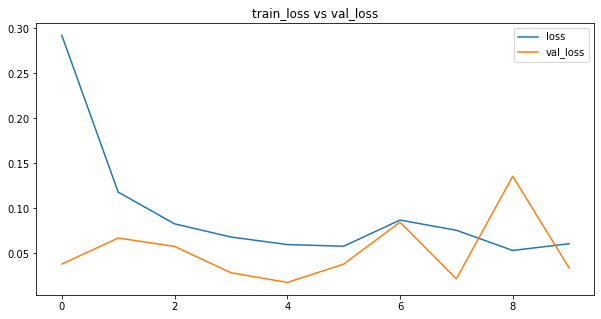

In [ ]:
# Plotting train_loss vs val_loss

plt.figure(figsize=(10,5))
plt.plot(result_VGG19.history["loss"],label="loss")
plt.plot(result_VGG19.history["val_loss"],label="val_loss")
plt.legend()
plt.title("train_loss vs val_loss")

Text(0.5, 1.0, 'train_accuracy vs Val_accuracy')

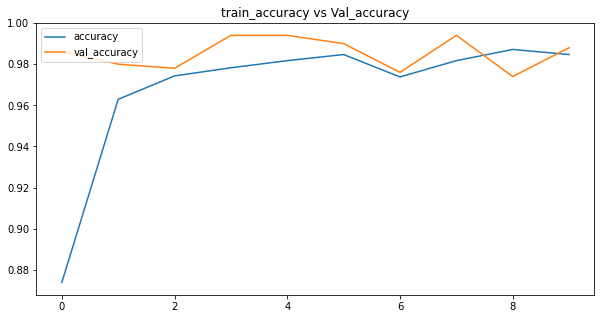

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(result_VGG19.history["acc"],label="accuracy")
plt.plot(result_VGG19.history["val_acc"],label="val_accuracy")
plt.legend(loc='upper left')
plt.title("train_accuracy vs Val_accuracy")

Text(0.5, 1.0, 'train_accuracy vs train recall')

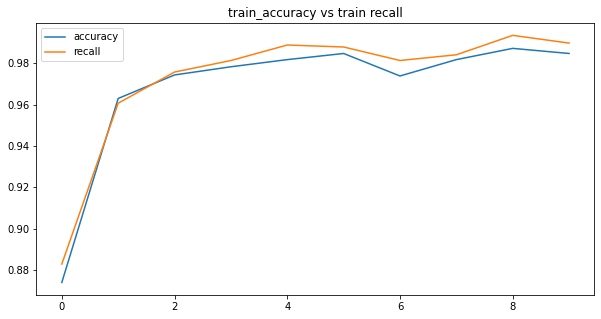

In [ ]:
# Plotting train_accuracy vs train_recall
plt.figure(figsize=(10,5))
plt.plot(result_VGG19.history["acc"],label="accuracy")
plt.plot(result_VGG19.history["recall_4"],label="recall")
plt.legend(loc='upper left')
plt.title("train_accuracy vs train recall")

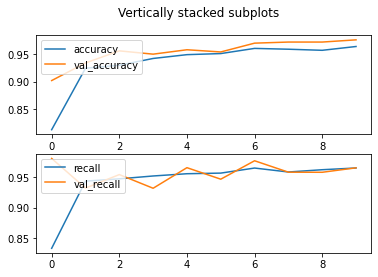

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')



ax1.plot(result_VGG19.history["acc"],label="accuracy")
ax1.plot(result_VGG19.history["val_acc"],label="val_accuracy")
ax1.legend(loc='upper left')


ax2.plot(result_VGG19.history["recall_4"],label="recall")
ax2.plot(result_VGG19.history["val_recall_4"],label="val_recall")
ax2.legend(loc='upper left')



In [ ]:
#save model to drive 
result_VGG19.model.save('/content/gdrive/MyDrive/kaggle_dataset/covid/model_vgg19')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/kaggle_dataset/covid/model_vgg19/assets


In [ ]:
result_VGG19.model.save('/content/gdrive/MyDrive/kaggle_dataset/covid/model_VGG19.h5')

# My model

In [ ]:
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
model=tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2),name="last_conv"))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25,name="dropout_10"))
model.add(Dense(1,activation="sigmoid",name="dense_19"))


model.compile(loss='binary_crossentropy',     
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc',tf.keras.metrics.Recall()])


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(result.model)

In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))
NUM_EPOCHS    = 25
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )

204
51


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
203/203 [==============================] - 1379s 7s/step - loss: 0.5435 - acc: 0.6802 - recall_1: 0.9119 - val_loss: 0.2057 - val_acc: 0.9100 - val_recall_1: 0.9736
Epoch 2/25
203/203 [==============================] - 66s 326ms/step - loss: 0.2430 - acc: 0.9118 - recall_1: 0.9308 - val_loss: 0.2602 - val_acc: 0.9140 - val_recall_1: 0.9887
Epoch 3/25
203/203 [==============================] - 66s 325ms/step - loss: 0.1875 - acc: 0.9361 - recall_1: 0.9577 - val_loss: 0.1844 - val_acc: 0.9380 - val_recall_1: 0.9023
Epoch 4/25
203/203 [==============================] - 67s 332ms/step - loss: 0.1525 - acc: 0.9492 - recall_1: 0.9569 - val_loss: 0.1485 - val_acc: 0.9520 - val_recall_1: 0.9811
Epoch 5/25
203/203 [==============================] - 69s 342ms/step - loss: 0.1541 - acc: 0.9549 - recall_1: 0.9731 - val_loss: 0.1751 - val_acc: 0.9380 - val_recall_1: 0.8943
Epoch 6/25
203/203 [==============================] - 70s 346ms/step - loss: 0.1553 - acc: 0.9510 - recall_1: 0.9565

Text(0.5, 1.0, 'train_loss vs val_loss')

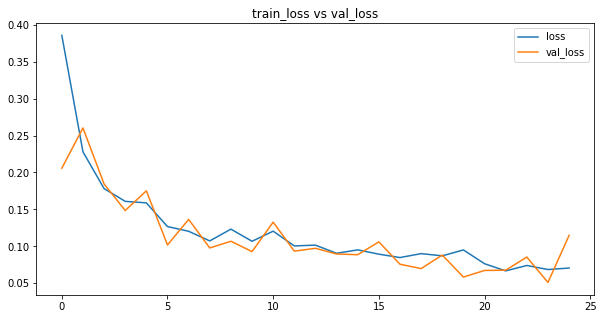

In [ ]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(result.history["loss"],label="loss")
plt.plot(result.history["val_loss"],label="val_loss")
plt.legend()
plt.title("train_loss vs val_loss")

Text(0.5, 1.0, 'train_accuracy vs train recall')

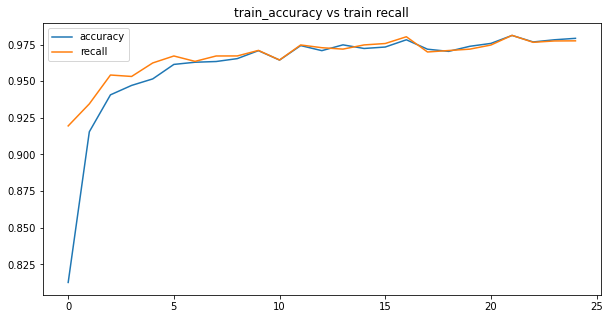

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(result.history["acc"],label="accuracy")
plt.plot(result.history["recall_1"],label="recall")
plt.legend(loc='upper left')
plt.title("train_accuracy vs train recall")

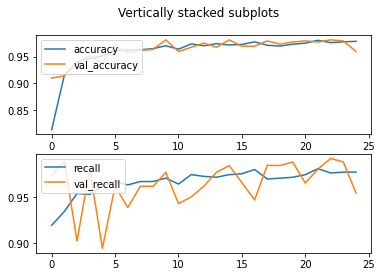

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')



ax1.plot(result.history["acc"],label="accuracy")
ax1.plot(result.history["val_acc"],label="val_accuracy")
ax1.legend(loc='upper left')


ax2.plot(result.history["recall_1"],label="recall")
ax2.plot(result.history["val_recall_1"],label="val_recall")
ax2.legend(loc='upper left')



In [ ]:
#save model to drive 
result.model.save('/content/gdrive/MyDrive/kaggle_dataset/covid/my_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/kaggle_dataset/covid/my_model/assets


In [ ]:
result.model.save('/content/gdrive/MyDrive/kaggle_dataset/covid/my_model.h5')


# Model testing 

In [ ]:
my_model = tf.keras.models.load_model('/content/gdrive/MyDrive/kaggle_dataset/covid/my_model.h5')

Text(0.5, 1.0, 'train_accuracy')

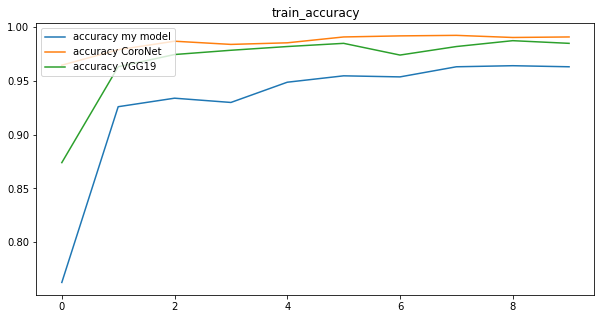

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(result.history["acc"],label="accuracy my model")
plt.plot(result_CoroNet.history["acc"],label="accuracy CoroNet")
plt.plot(result_VGG19.history["acc"],label="accuracy VGG19")
plt.legend(loc='upper left')
plt.title("train_accuracy")

Text(0.5, 1.0, 'train_accuracy')

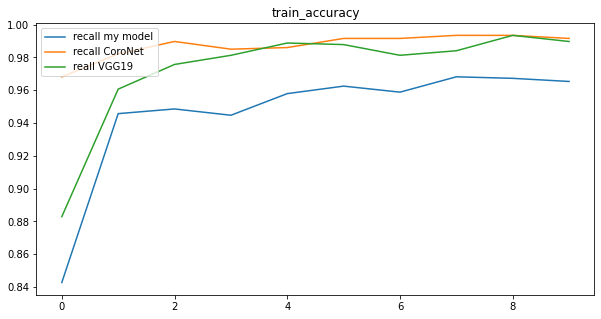

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(result.history["recall_5"],label="recall my model")
plt.plot(result_CoroNet.history["recall_3"],label="recall CoroNet")
plt.plot(result_VGG19.history["recall_4"],label="reall VGG19")
plt.legend(loc='upper left')
plt.title("train_accuracy")

In [ ]:
def predict_covid(trained_model,image_path):
  img=  image.load_img(image_path,target_size=(256,256))
  img=image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  p=trained_model.predict(img)
  return int(p[0][0])

In [ ]:
print(predict_covid(result_CoroNet.model,"/content/covid2.jpg"))


0

In [ ]:
def test_model(dataset_path,trained_model):
  data = {}

  for i in ['COVID', 'NORMAL']:

      data[i] = glob.glob(dataset_path+"/{}/*.png".format(i))
  y_pred = []
  y = []
  tag = 0
  data_size=1000
  #We'll have the Y as following 0 for COVID19 1 for NORMAL 
  for folder in data:
      print("Loading data from :"+folder)
      i=0
      for file in data[folder]:
          if i == data_size :
            break
          y_pred.append(predict_covid(trained_model,file))

          y.append(tag)
          i+=1
      print("number of images :", i)    
      print("__________________________")
      tag += 1
  y_pred=np.array(y_pred)
  y=np.array(y)
  cm =confusion_matrix(y_pred,y)

  print("true possitive:",cm[0][0])
  print("false possitive:",cm[0][1])
  print("false negative:",cm[1][0])
  print("true negative:",cm[1][1])
  
  sns.heatmap(cm,cmap="plasma",annot=True)

  



Loading data from :COVID
number of images : 1000
__________________________
Loading data from :NORMAL
number of images : 1000
__________________________
true possitive: 869
false possitive: 3
false negative: 131
true negative: 997


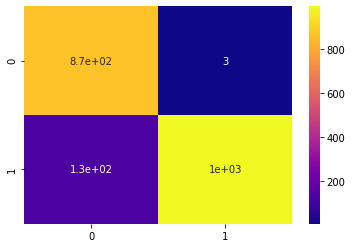

In [ ]:
test_model(DATASET_PATH,my_model)

Loading data from :COVID
number of images : 100
__________________________
Loading data from :NORMAL
number of images : 100
__________________________
true possitive: 78
false possitive: 0
false negative: 22
true negative: 100


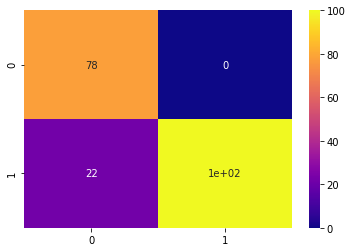

In [ ]:
test_model(DATASET_PATH,result_VGG19.model)

# Grad-CAM class activation visualization

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])    
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

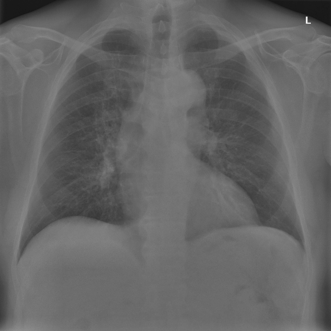

In [ ]:
#model_builder = keras.applications.xception.Xception
img_size = (256, 256)


last_conv_layer_name = "last_conv"
classifier_layer_names = [
    "activation_6",
    "max_pooling2d_2",
    "flatten_1",

]
#img_path="/content/gdrive/MyDrive/kaggle_dataset/covid/COVID-19 Radiography Database/NORMAL/NORMAL (900).png"
img_path="/content/gdrive/MyDrive/kaggle_dataset/covid/COVID-19 Radiography Database/COVID/COVID (1001).png"


display(Image(img_path))

Predicted: COVID


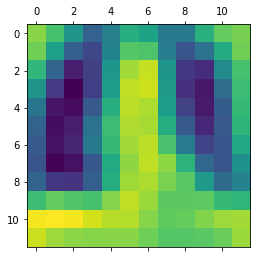

In [ ]:
# Prepare image
#img_array = preprocess_input(get_img_array(img_path, size=img_size))
img=  image.load_img(img_path,target_size=(256,256))
img=image.img_to_array(img)
img = np.expand_dims(img,axis=0)
# Make model
model = result.model

# Print what the top predicted class is
preds = model.predict(img)
preds = int(preds[0][0])
print("Predicted:", classes[preds])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

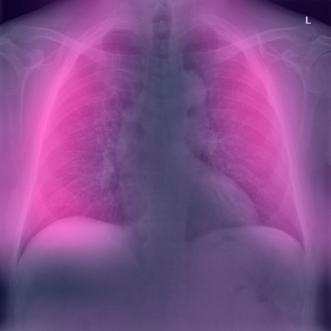

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("rocket")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.9+ img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "result.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))